In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow import MlflowClient 
from mlflow.models import infer_signature
import mlflow
plt.style.use('fivethirtyeight')

In [2]:
ab_df = pd.read_csv('../../data/interim/absences_per_day.csv', sep=',')
#only keep columns index and count 
ab_df = ab_df[['index', 'count']]
#rename index to date
ab_df = ab_df.rename(columns={'index': 'date'})
ab_df['date'] = pd.to_datetime(ab_df['date'])
# drop data older than 2023-03-01
ab_df = ab_df[ab_df['date'] < '2023-03-01']

ab_df

,date,count
0,2020-01-02,2
1,2020-01-03,2
2,2020-01-04,2
3,2020-01-05,1
4,2020-01-06,1
...,...,...
1149,2023-02-24,194
1150,2023-02-25,216
1151,2023-02-26,68
1152,2023-02-27,114


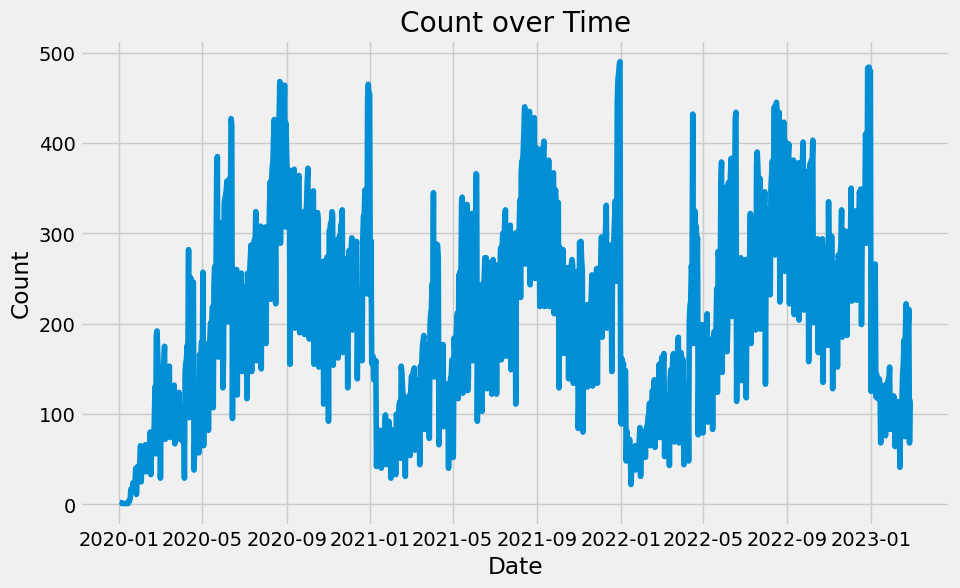

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time')
plt.grid(True)
plt.show()

In [4]:
split_date = '01-Jul-2022'
ab_train = ab_df.loc[ab_df['date'] <= split_date].copy()
ab_test = ab_df.loc[ab_df['date'] > split_date].copy()

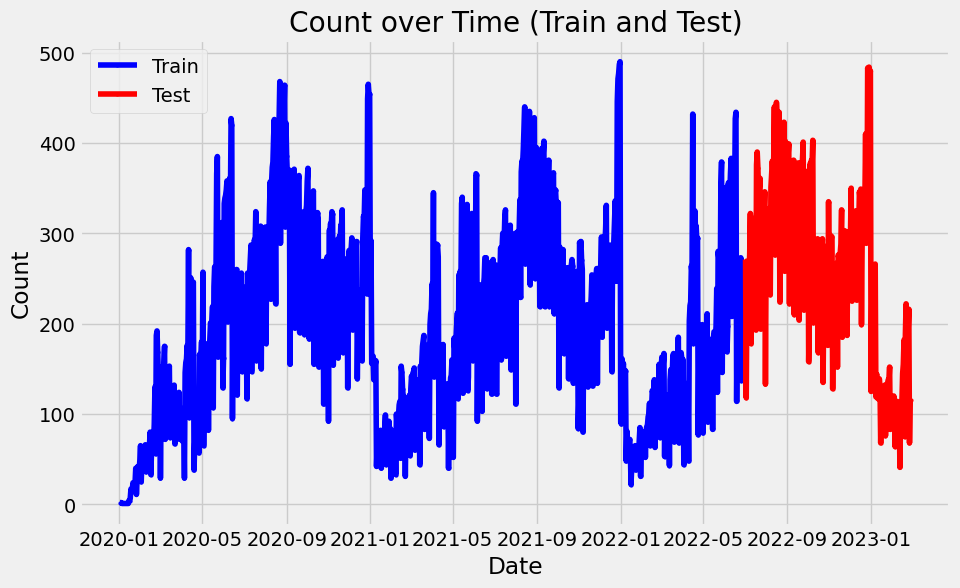

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='blue', label='Train')

# Plot the test set with another color (e.g., red)
plt.plot(ab_test['date'], ab_test['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)
plt.show()

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(ab_train, label='count')
X_test, y_test = create_features(ab_test, label='count')

C:\Users\jakob\AppData\Local\Temp\ipykernel_24116\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\jakob\AppData\Local\Temp\ipykernel_24116\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [8]:
mlflow.xgboost.autolog()

In [9]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
       
y_pred = reg.predict(X_test)


2023/08/04 09:40:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8bac584fd2f44fe1a8d28dea0c6702a8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
2023/08/04 09:40:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\models\signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enfo

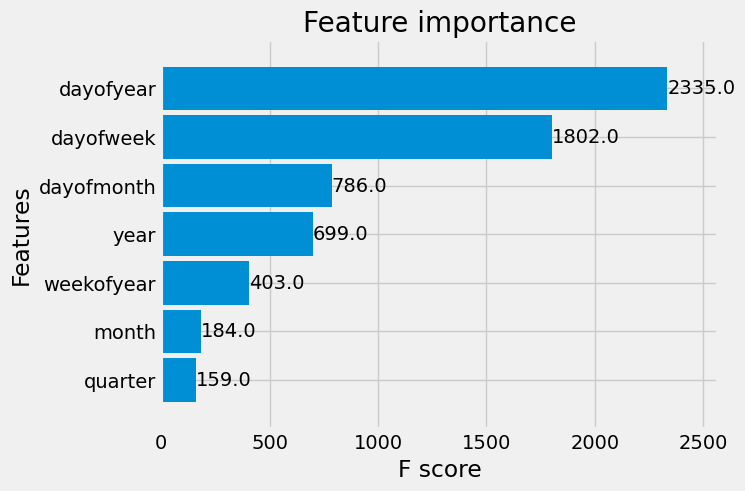

In [10]:
_ = plot_importance(reg, height=0.9)


In [11]:
ab_test['absence_Prediction'] = reg.predict(X_test)
count_all = pd.concat([ab_test, ab_train], sort=False)


2023/08/04 09:41:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


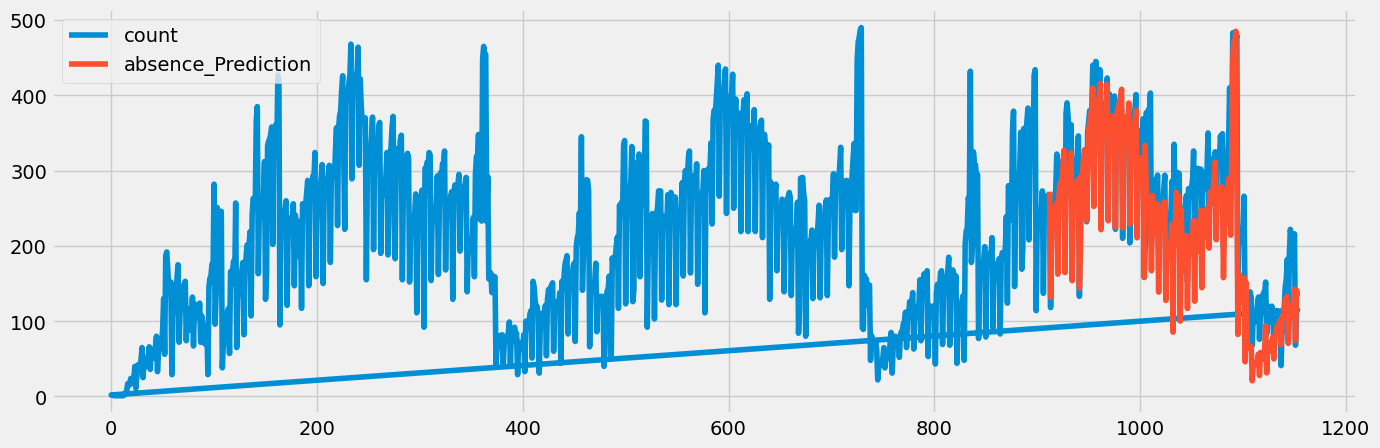

In [12]:
_ = count_all[['count','absence_Prediction']].plot(figsize=(15, 5))


In [13]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [20]:
mlflow.set_tracking_uri('./mlruns')
mlflow.set_experiment('singlets')
experiment = mlflow.get_experiment_by_name('singlets')
client = MlflowClient()

run = client.create_run(experiment.experiment_id)

with mlflow.start_run(run_id=run.info.run_id) as run:

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    mlflow.xgboost.log_model(reg, 'model')

In [15]:
# Calculate absolute percentage errors
ape = np.abs((y_test - y_pred) / y_test) * 100

# Calculate MAPE
mape = np.mean(ape)
print(f"MAPE: {mape:.2f}%")


MAPE: 18.97%


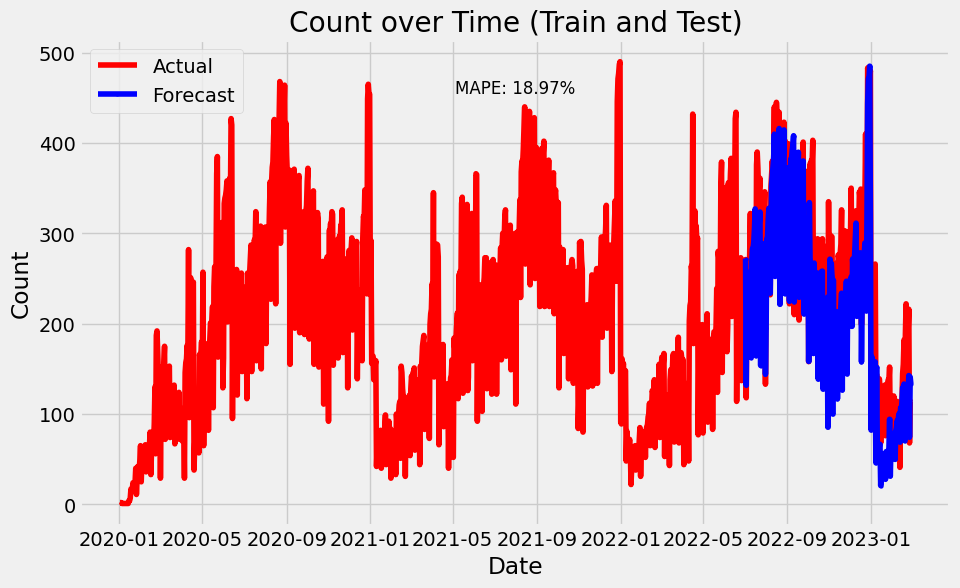

In [17]:
plt.figure(figsize=(10, 6))

# Plot the test set with another color (e.g., red)
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1, color='red', label='Actual')
plt.plot(ab_test['date'], y_pred, marker='o', linestyle='-', markersize=2, color='blue', label='Forecast')

#plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)

plt.text(0.5, 0.9, f'MAPE: {mape:.2f}%', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()

In [18]:
ab_df['date']

0      2020-01-02
1      2020-01-03
2      2020-01-04
3      2020-01-05
4      2020-01-06
          ...    
1149   2023-02-24
1150   2023-02-25
1151   2023-02-26
1152   2023-02-27
1153   2023-02-28
Name: date, Length: 1154, dtype: datetime64[ns]

In [19]:
result_df = pd.DataFrame({'date': ab_test['date'], 'count': y_pred})


result_df = pd.concat([pd.DataFrame({'date': ab_df['date'], 'count': ab_df['count']}), result_df])

# Sort the DataFrame by 'date'
result_df = result_df.sort_values(by='date')
result_df

,date,count
0,2020-01-02,2.000000
1,2020-01-03,2.000000
2,2020-01-04,2.000000
3,2020-01-05,1.000000
4,2020-01-06,1.000000
...,...,...
1151,2023-02-26,74.350281
1152,2023-02-27,114.000000
1152,2023-02-27,140.957382
1153,2023-02-28,115.000000
